In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fashionmnist/t10k-labels-idx1-ubyte
/kaggle/input/fashionmnist/t10k-images-idx3-ubyte
/kaggle/input/fashionmnist/fashion-mnist_test.csv
/kaggle/input/fashionmnist/fashion-mnist_train.csv
/kaggle/input/fashionmnist/train-labels-idx1-ubyte
/kaggle/input/fashionmnist/train-images-idx3-ubyte


**LIBRARIES**

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM,GRU,SimpleRNN
from tensorflow.keras import datasets, layers, models
from sklearn.metrics import confusion_matrix, recall_score
from keras.models import Sequential
import keras 
from kerastuner.tuners import RandomSearch

2024-06-28 17:17:36.365722: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-28 17:17:36.365837: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-28 17:17:36.537205: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/tmp/ipykernel_24/1662087411.py:14: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


**LOADING DATASET**

In [3]:
tr_df = pd.read_csv('/kaggle/input/fashionmnist/fashion-mnist_train.csv')
ts_df = pd.read_csv('/kaggle/input/fashionmnist/fashion-mnist_test.csv')

tr_img = tr_df.iloc[:, 1:].values.reshape(-1, 28, 28, 1)
tr_lbl = tr_df.iloc[:, 0].values
ts_img = ts_df.iloc[:, 1:].values.reshape(-1, 28, 28, 1)
ts_lbl = ts_df.iloc[:, 0].values

**BASIC EDA**

In [4]:
#no of rows & features in our dataset summary 

print("Train Shape:", tr_df.shape) #train
print("Test Shape:", ts_df.shape)  #test
print("Train Image Shape:", tr_img.shape)  #train image 
print("Train Label Shape:", tr_lbl.shape)  #train label 
print("Test Image Shape:", ts_img.shape)  #test image
print("Test Label Shape:", ts_lbl.shape)  #test label

Train Shape: (60000, 785)
Test Shape: (10000, 785)
Train Image Shape: (60000, 28, 28, 1)
Train Label Shape: (60000,)
Test Image Shape: (10000, 28, 28, 1)
Test Label Shape: (10000,)


In [5]:
#setting execution output to display all the features

pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 784) #we have 784 featires
pd.set_option('display.width', 1000)

In [6]:
#basic stats

ts_df.describe()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,pixel80,pixel81,pixel82,pixel83,pixel84,pixel85,pixel86,pixel87,pixel88,pixel89,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99,pixel100,pixel101,pixel102,pixel103,pixel104,pixel105,pixel106,pixel107,pixel108,pixel109,pixel110,pixel111,pixel112,pixel113,pixel114,pixel115,pixel116,pixel117,pixel118,pixel119,pixel120,pixel121,pixel122,pixel123,pixel124,pixel125,pixel126,pixel127,pixel128,pixel129,pixel130,pixel131,pixel132,pixel133,pixel134,pixel135,pixel136,pixel137,pixel138,pixel139,pixel140,pixel141,pixel142,pixel143,pixel144,pixel145,pixel146,pixel147,pixel148,pixel149,pixel150,pixel151,pixel152,pixel153,pixel154,pixel155,pixel156,pixel157,pixel158,pixel159,pixel160,pixel161,pixel162,pixel163,pixel164,pixel165,pixel166,pixel167,pixel168,pixel169,pixel170,pixel171,pixel172,pixel173,pixel174,pixel175,pixel176,pixel177,pixel178,pixel179,pixel180,pixel181,pixel182,pixel183,pixel184,pixel185,pixel186,pixel187,pixel188,pixel189,pixel190,pixel191,pixel192,pixel193,pixel194,pixel195,pixel196,pixel197,pixel198,pixel199,pixel200,pixel201,pixel202,pixel203,pixel204,pixel205,pixel206,pixel207,pixel208,pixel209,pixel210,pixel211,pixel212,pixel213,pixel214,pixel215,pixel216,pixel217,pixel218,pixel219,pixel220,pixel221,pixel222,pixel223,pixel224,pixel225,pixel226,pixel227,pixel228,pixel229,pixel230,pixel231,pixel232,pixel233,pixel234,pixel235,pixel236,pixel237,pixel238,pixel239,pixel240,pixel241,pixel242,pixel243,pixel244,pixel245,pixel246,pixel247,pixel248,pixel249,pixel250,pixel251,pixel252,pixel253,pixel254,pixel255,pixel256,pixel257,pixel258,pixel259,pixel260,pixel261,pixel262,pixel263,pixel264,pixel265,pixel266,pixel267,pixel268,pixel269,pixel270,pixel271,pixel272,pixel273,pixel274,pixel275,pixel276,pixel277,pixel278,pixel279,pixel280,pixel281,pixel282,pixel283,pixel284,pixel285,pixel286,pixel287,pixel288,pixel289,pixel290,pixel291,pixel292,pixel293,pixel294,pixel295,pixel296,pixel297,pixel298,pixel299,pixel300,pixel301,pixel302,pixel303,pixel304,pixel305,pixel306,pixel307,pixel308,pixel309,pixel310,pixel311,pixel312,pixel313,pixel314,pixel315,pixel316,pixel317,pixel318,pixel319,pixel320,pixel321,pixel322,pixel323,pixel324,pixel325,pixel326,pixel327,pixel328,pixel329,pixel330,pixel331,pixel332,pixel333,pixel334,pixel335,pixel336,pixel337,pixel338,pixel339,pixel340,pixel341,pixel342,pixel343,pixel344,pixel345,pixel346,pixel347,pixel348,pixel349,pixel350,pixel351,pixel352,pixel353,pixel354,pixel355,pixel356,pixel357,pixel358,pixel359,pixel360,pixel361,pixel362,pixel363,pixel364,pixel365,pixel366,pixel367,pixel368,pixel369,pixel370,pixel371,pixel372,pixel373,pixel374,pixel375,pixel376,pixel377,pixel378,pixel379,pixel380,pixel381,pixel382,pixel383,pixel384,pixel385,pixel386,pixel387,pixel388,pixel389,pixel390,pixel391,...,pixel393,pixel394,pixel395,pixel396,pixel397,pixel398,pixel399,pixel400,pixel401,pixel402,pixel403,pixel404,pixel405,pixel406,pixel407,pixel408,pixel409,pixel410,pixel411,pixel412,pixel413,pixel414,pixel415,pixel416,pixel417,pixel418,pixel419,pixel420,pixel421,pixel422,pixel423,pixel424,pixel425,pixel426,pixel427,pixel428,pixel429,pixel430,pixel431,pixel432,pixel433,pixel434,pixel435,pixel436,pixel437,pixel438,pixel439,pixel440,pixel441,pixel442,pixel443,pixel444,pixel445,pixel446,pixel447,pixel448,pixel449,pixel450,pixel451,pixel452,pixel453,pixel454,pixel455,pixel456,pi

In [7]:
#min & max values in all the features 
#it is 0 - 255, not bad 


print(tr_df.min())
print(tr_df.max())

label       0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
           ..
pixel780    0
pixel781    0
pixel782    0
pixel783    0
pixel784    0
Length: 785, dtype: int64
label         9
pixel1       16
pixel2       36
pixel3      226
pixel4      164
           ... 
pixel780    255
pixel781    255
pixel782    255
pixel783    255
pixel784    170
Length: 785, dtype: int64


In [8]:
#unique labels in train dataset
#there are 10 unique labels 


print("Number of unique labels in Train:", len(tr_df.iloc[:, 0].unique()))

Number of unique labels in Train: 10


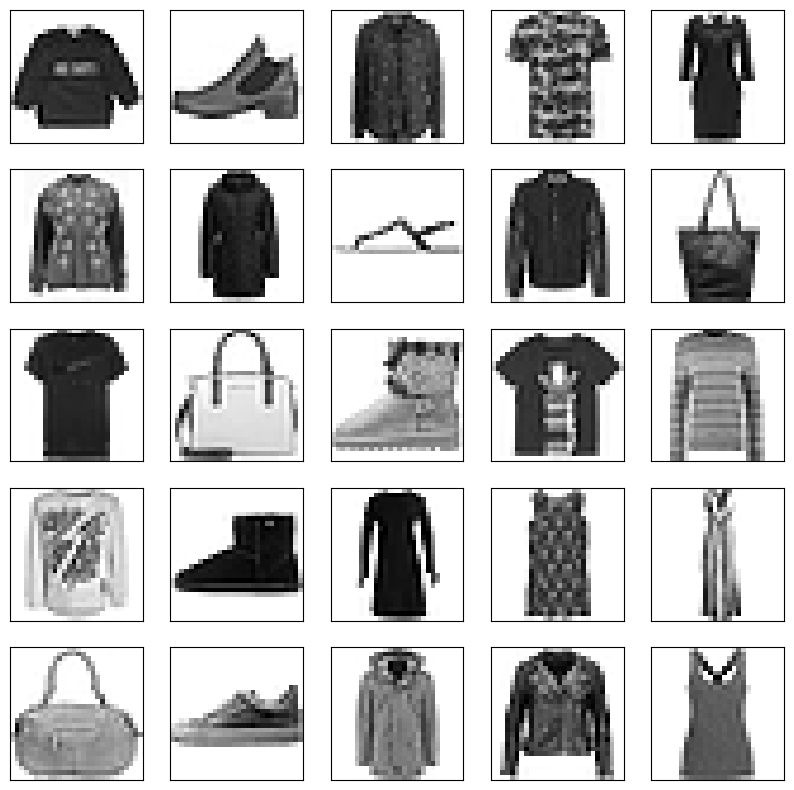

In [9]:
#lets visualise some image from our dataset


plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(tr_df.iloc[i, 1:].values.reshape((28,28)), cmap=plt.cm.binary)
plt.show()

**DATA PREPROCESSING**

In [10]:
#neural networks wokes good with normalized data (scaled data) i.e; 0-1 sclae
#makes sence as we have the min value as 0 and max value as 255, not bad

tr_img, ts_img = tr_img / 255.0, ts_img / 255.0

**MODEL SELECTION**

In [11]:
#simple ANN --> simple RNN model 

model1 = models.Sequential()

model1.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Conv2D(64, (3, 3), activation='relu'))

model1.add(layers.Reshape((-1, 64))) 
model1.add(layers.SimpleRNN(32)) 

model1.add(layers.Dense(64, activation='relu'))
model1.add(layers.Dense(10))
model1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
#testing simple RNN model

history1 = model1.fit(tr_img, tr_lbl, epochs=20, 
                    validation_data=(ts_img, ts_lbl))

Epoch 1/20
  56/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.3413 - loss: 1.9833

I0000 00:00:1719595088.976323      74 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.7395 - loss: 0.7457 - val_accuracy: 0.8747 - val_loss: 0.3513
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8721 - loss: 0.3491 - val_accuracy: 0.8855 - val_loss: 0.3035
Epoch 3/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8901 - loss: 0.2977 - val_accuracy: 0.8971 - val_loss: 0.2746
Epoch 4/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9001 - loss: 0.2667 - val_accuracy: 0.9038 - val_loss: 0.2611
Epoch 5/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9119 - loss: 0.2348 - val_accuracy: 0.9031 - val_loss: 0.2607
Epoch 6/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9166 - loss: 0.2234 - val_accuracy: 0.9025 - val_loss: 0.2640
Epoch 7/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9233 - loss: 0.2073 - val_accuracy: 0.8967 - val_loss: 0.2824
Epoch 8/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9280 - loss: 0.1924 - val_accura

In [13]:
#evaluating the simple RNN model

ts_loss, ts_acc = model1.evaluate(ts_img, ts_lbl, verbose=2)
print('\nTest Accuracy:', ts_acc)

313/313 - 1s - 2ms/step - accuracy: 0.9036 - loss: 0.3283

Test Accuracy: 0.9035999774932861


In [14]:
#sensitivity testing of simple RNN model

pred = model1.predict(ts_img)
pred_lbl = np.argmax(pred, axis=1)
cm = confusion_matrix(ts_lbl, pred_lbl)
sensitivity = recall_score(ts_lbl, pred_lbl, average='micro')
print("Sensitivity: ", sensitivity)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Sensitivity:  0.9036


In [15]:
#simple ANN --> RNN LSTM

model2 = models.Sequential()

model2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))

model2.add(layers.Reshape((-1, 64))) 
model2.add(layers.LSTM(32)) 

model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.Dense(10))
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
#testing RNN LSTM model

history2 = model2.fit(tr_img, tr_lbl, epochs=20, 
                    validation_data=(ts_img, ts_lbl))

Epoch 1/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.6592 - loss: 0.9179 - val_accuracy: 0.8415 - val_loss: 0.4229
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8463 - loss: 0.4145 - val_accuracy: 0.8757 - val_loss: 0.3446
Epoch 3/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8786 - loss: 0.3331 - val_accuracy: 0.8819 - val_loss: 0.3166
Epoch 4/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8909 - loss: 0.2984 - val_accuracy: 0.9033 - val_loss: 0.2649
Epoch 5/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9032 - loss: 0.2605 - val_accuracy: 0.9026 - val_loss: 0.2648
Epoch 6/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9123 - loss: 0.2405 - val_accuracy: 0.9097 - val_loss: 0.2487
Epoch 7/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9185 - loss: 0.2234 - val_accuracy: 0.9062 - val_loss: 0.2558
Epoch 8/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9232 - loss: 0

In [17]:
#evaluating RNN LSTM model

ts_loss, ts_acc = model2.evaluate(ts_img, ts_lbl, verbose=2)
print('\nTest Accuracy:', ts_acc)

313/313 - 1s - 2ms/step - accuracy: 0.9126 - loss: 0.2966

Test Accuracy: 0.9125999808311462


In [18]:
#sensitivity testing of RNN LSTM model

pred = model2.predict(ts_img)
pred_lbl = np.argmax(pred, axis=1)
cm = confusion_matrix(ts_lbl, pred_lbl)
sensitivity = recall_score(ts_lbl, pred_lbl, average='micro')
print("Sensitivity: ", sensitivity)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Sensitivity:  0.9126


In [19]:
#simple ANN --> RNN GRU

model3 = models.Sequential()

model3.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Conv2D(64, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Conv2D(64, (3, 3), activation='relu'))

model3.add(layers.Reshape((-1, 64))) 
model3.add(layers.GRU(32)) 

model3.add(layers.Dense(64, activation='relu'))
model3.add(layers.Dense(10))
model3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [20]:
#testing RNN GRU model

history3 = model3.fit(tr_img, tr_lbl, epochs=50, 
                    validation_data=(ts_img, ts_lbl))

Epoch 1/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.6752 - loss: 0.8776 - val_accuracy: 0.8431 - val_loss: 0.4269
Epoch 2/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.8576 - loss: 0.3956 - val_accuracy: 0.8851 - val_loss: 0.3244
Epoch 3/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.8811 - loss: 0.3274 - val_accuracy: 0.8791 - val_loss: 0.3264
Epoch 4/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.8959 - loss: 0.2847 - val_accuracy: 0.8928 - val_loss: 0.2936
Epoch 5/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9061 - loss: 0.2551 - val_accuracy: 0.8988 - val_loss: 0.2733
Epoch 6/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9130 - loss: 0.2389 - val_accuracy: 0.9074 - val_loss: 0.2557
Epoch 7/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9217 - loss: 0.2180 - val_accuracy: 0.8971 - val_loss: 0.2862
Epoch 8/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9242 - loss: 0

In [21]:
#evaluating RNN GRU model

ts_loss, ts_acc = model3.evaluate(ts_img, ts_lbl, verbose=2)
print('\nTest Accuracy:', ts_acc)

313/313 - 1s - 2ms/step - accuracy: 0.9035 - loss: 0.4392

Test Accuracy: 0.9035000205039978


In [22]:
#sensitivity testing of RNN GRU model

pred = model3.predict(ts_img)
pred_lbl = np.argmax(pred, axis=1)
cm = confusion_matrix(ts_lbl, pred_lbl)
sensitivity = recall_score(ts_lbl, pred_lbl, average='micro')
print("Sensitivity: ", sensitivity)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Sensitivity:  0.9035


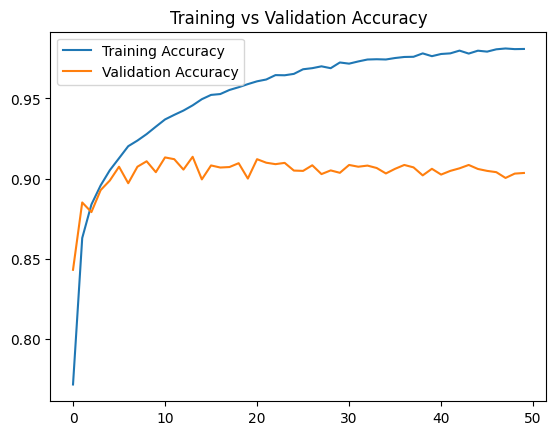

In [23]:
#plot for train and validation accuracy 

from tensorflow.keras.callbacks import EarlyStopping

#access training and validation accuracy after training
train_acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

#plot or compare the accuracy values
import matplotlib.pyplot as plt

plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()


**MODEL DEVELOPMENT & DEPLOYMENT**

In [24]:
#model is overfitting 
#we need to reduce the model complexity 
#we will remove two layers one layer max polling and the other convolution 2D 


model_1 = models.Sequential()

model_1.add(layers.Conv2D(32, (3, 3), activation='sigmoid', input_shape=(28, 28, 1)))
model_1.add(layers.MaxPooling2D((2, 2)))
model_1.add(layers.Conv2D(64, (3, 3), activation='relu'))
#/model3.add(layers.MaxPooling2D((2, 2)))
#model3.add(layers.Conv2D(64, (3, 3), activation='relu'))

model_1.add(layers.Reshape((-1, 64))) 
model_1.add(layers.GRU(32)) 

model_1.add(layers.Dense(64, activation='tanh'))
model_1.add(layers.Dense(10))
model_1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [25]:
#testing RNN GRU model

history_1 = model_1.fit(tr_img, tr_lbl, epochs=50, 
                    validation_data=(ts_img, ts_lbl))

Epoch 1/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.4457 - loss: 1.4637 - val_accuracy: 0.7607 - val_loss: 0.6876
Epoch 2/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.7662 - loss: 0.6540 - val_accuracy: 0.8012 - val_loss: 0.5495
Epoch 3/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.8024 - loss: 0.5497 - val_accuracy: 0.8140 - val_loss: 0.4981
Epoch 4/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.8228 - loss: 0.4894 - val_accuracy: 0.8244 - val_loss: 0.4699
Epoch 5/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.8382 - loss: 0.4479 - val_accuracy: 0.8365 - val_loss: 0.4500
Epoch 6/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.8466 - loss: 0.4276 - val_accuracy: 0.8462 - val_loss: 0.4108
Epoch 7/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.8530 - loss: 0.3985 - val_accuracy: 0.8589 - val_loss: 0.3917
Epoch 8/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.8566 - loss: 0

In [26]:
#evaluating RNN GRU model
#we removed two layers 

ts_loss, ts_acc = model_1.evaluate(ts_img, ts_lbl, verbose=2)
print('\nTest Accuracy:', ts_acc)

313/313 - 1s - 4ms/step - accuracy: 0.8971 - loss: 0.2861

Test Accuracy: 0.8970999717712402


In [27]:
#sensitivity after removing 2 layers testing of RNN GRU model

pred = model_1.predict(ts_img)
pred_lbl = np.argmax(pred, axis=1)
cm = confusion_matrix(ts_lbl, pred_lbl)
sensitivity = recall_score(ts_lbl, pred_lbl, average='micro')
print("Sensitivity: ", sensitivity)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Sensitivity:  0.8971


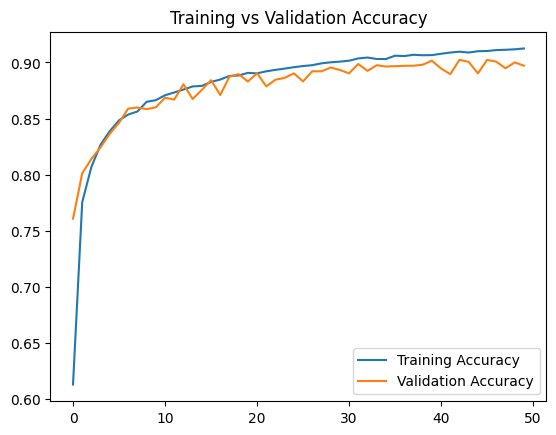

In [28]:
#plot for train and validation accuracy 
#after removing two layers 


from tensorflow.keras.callbacks import EarlyStopping

#access training and validation accuracy after training
train_acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']

#plot or compare the accuracy values
import matplotlib.pyplot as plt

plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()


As we can see we started with 20 Epoches and tried all Simple RNN, GRU, LSTM and faced overfitting. We reduced the layer model complexity in that we removed two layers on eof MaxPolling andf other of Convolution2D from RNN GRU other than that what we did is we replcaed two activation with sigmoid and tanh as we used ReLU everywhere. We now got a good train accuracy of 0.9375 (93.75%) and valid accuracy of 0.9040 (90.40%) which is better than previous models. That is approx of 3% of difference that is not a major concern in this dataset.


For more better results keep on evaluating and updating the model. Play with activations and optimizations most importantly use dropout layer and you will find more near to perfect accuracy. You can monitor other metrics to like Loss Function & F-1 Score etcetre...